# WEEK 9 ASSIGNMENT
## Analysis of WRF Hurricane Katrina data: Part II
- Le'ts continue analysis of WRF simulation output of Hurricane Katrina!
<br><br>
- *Data - all at the SURFACE, and every 3 hours*
  - Reflect (reflectivity; precipitation intensity; dBZ)
  - Pres (pressure; lower pressures = stronger hurricane; mb)
  - Usfc (u-component, east-west, of wind; m/s)
  - Vsfc (v-component, north-south, of wind; m/s)

In [11]:
import xarray as xr
import numpy as np
import glob
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### You'll want to copy the code from Q1 and Q2 in your Week 9 In-Module Exercises to the start of this assignment to read in + do some initial processing of the data

In [2]:
# Use glob to find all matching files starting with 'wrfout'
file_path = './week9_data/wrfout*'
file_list = sorted(glob.glob(file_path)) # Sort also
ds_list=[] # List to store datasets

# Loop through files
for file in file_list:
    ds = xr.open_dataset(file)
    ds_list.append(ds)

# Concat on new time dimension
combined_ds = xr.concat(ds_list, dim='time')

from datetime import datetime # Import necessary module

times = [] # List to store datetimes
for file in file_list:
    # Split file name string to get characters only after _d01_
    timestamp_str = file.split("_d01_")[-1]
    # Parse the string to grab the datetime object
    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d_%H_%M_%S.nc")
    times.append(timestamp)

# Assign time dimension the time coordinates
combined_ds = combined_ds.assign_coords(time=times)
combined_ds

<xarray.Dataset> Size: 5MB
Dimensions:  (time: 25, lat: 79, lon: 89)
Coordinates:
  * lat      (lat) float32 316B 20.32 20.56 20.8 21.04 ... 38.59 38.83 39.07
  * lon      (lon) float32 356B -99.88 -99.62 -99.37 ... -77.89 -77.64 -77.38
  * time     (time) datetime64[ns] 200B 2005-08-27T12:00:00 ... 2005-08-30T12...
Data variables:
    Lat      (time, lat, lon) float32 703kB 20.32 20.35 20.37 ... 39.1 39.07
    Lon      (time, lat, lon) float32 703kB -99.88 -99.62 ... -75.31 -75.0
    Landuse  (time, lat, lon) float32 703kB 7.0 7.0 8.0 8.0 ... 6.0 16.0 16.0
    Pres     (time, lat, lon) float32 703kB 1.008e+03 1.008e+03 ... 1.011e+03
    Usfc     (time, lat, lon) float32 703kB 0.1631 0.389 ... -0.6021 -0.3277
    Vsfc     (time, lat, lon) float32 703kB 0.8045 0.8172 0.7892 ... 1.187 1.448
    Reflect  (time, lat, lon) float32 703kB 0.001 -20.0 -20.0 ... -2.284 -2.281

### (1) Let's track the hurricane over time and plot its track!
- (a.) How we'll do this: find the (lat,lon) of the MINIMUM in surface pressure at each time (note: a hurricane is a strong low pressure system, with some other special characteristics)
  - You're going to do this for each time, and save your lats and lons of the minimum value of surface pressure in numpy arrays, one each for lat and lon
  - You will also want to save the actual minimum values of pressure to an array for future use
  - **IMPORTANT HINT**: idxmin/idxmax can only operate over 1 dimension for evaluation.  argmax, argmin, can operate over multiple dimensions for evaluation. What does argmin or argmax actually return back? https://docs.xarray.dev/en/stable/generated/xarray.DataArray.argmax.html
<br><br>
- (b.) Create a map (with coastlines, statelines, etc.) with these 25 locations plotted, as a plot of the hurricane's track
<br><br>
    - *Optional challenges*:
      - color code the dots by time, or minimum pressure, etc.
      - label the 00:00 observation for each day with the date of that day (so you'd have 4 labeled dots)
      - replot your plots in (3) to include a dot of the location of the minimum pressure in the hurricane for each of the times in a given subplot

In [46]:
# (a) Minimum in surface pressure - find at each time

# Find min pressure spatial indices for each time
min_pres_indices = combined_ds['Pres'].argmin(dim=['lat','lon'])

# Get min pressure points from those indices
min_pres_points = combined_ds['Pres'][min_pres_indices]

min_pres_lats = min_pres_points.lat.values
min_pres_lons = min_pres_points.lon.values

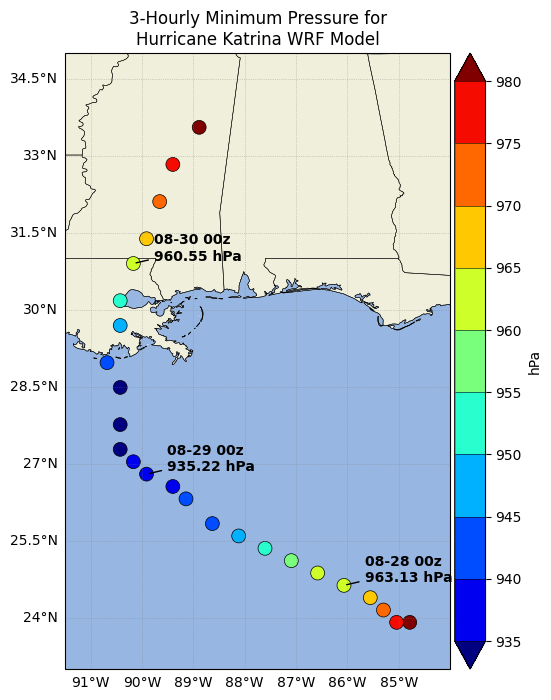

In [125]:
# (b)  Plot the hurricane track over time on a map!

from matplotlib.colors import ListedColormap, BoundaryNorm

fig, ax = plt.subplots(1,1, figsize=(6,8), subplot_kw={'projection': ccrs.PlateCarree()})

levels = np.arange(935,981,5)
cmap1 = plt.get_cmap('jet')
norm1 = BoundaryNorm(levels, ncolors=cmap1.N, extend='both') # Get discrete colormap

ax.set_extent([-91.5,-84,23,35])

cb = ax.scatter(min_pres_lons, min_pres_lats, c=min_pres_points,
                s=100, linewidths=0.5, edgecolors='black', 
                cmap=cmap1, norm=norm1, transform=ccrs.PlateCarree(), zorder=2)

ax.add_feature(cfeature.STATES, edgecolor="black", linewidths=0.35, alpha=1)
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidths=0.35, alpha=1)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.6, linestyle=':', zorder=1)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Plot txt labels for 00z each day
days = min_pres_points.time.sel(time=min_pres_points.time.dt.hour == 0) # Select 00z times
day_p = min_pres_points.sel(time=days)

# Loop through each 00z time
for day in day_p.time:
    p = day_p.sel(time=day)
    lon, lat, val = p.lon.values, p.lat.values, p.values
    label = f'{pd.to_datetime(day.values).strftime("%m-%d %Hz")}\n{val:.2f} hPa'

    # Annotate each 00z point with label and arrow
    ax.annotate(
        text=label,
        xy=(lon, lat), # Point of interest
        xytext=(lon + 0.4, lat), # Label position
        xycoords='data',
        arrowprops=dict( # Arrow attributes
            arrowstyle='-',
            color='black',
            lw=1
        ),
        fontsize=10,
        weight='bold',
        ha='left', # Horizontal alignment
        va='bottom' # Vertical alignment
    )

ax.set_title('3-Hourly Minimum Pressure for\nHurricane Katrina WRF Model')

cbar = plt.colorbar(cb, ax=ax, orientation='vertical',
                    fraction=0.07, pad=0.01, extend='both', 
                    drawedges=True)
cbar.set_label('hPa')
plt.show()



### (2) Now, let's calculate how the DOMAIN-AVERAGE WIND SPEED changes over time
- domain-average wind speed:  is what it sounds like.  Find the average wind speed at each time over the full domain of your data (i.e., no slicing).  You'll end up with a time series of domain-average wind speed!
<br><br>
- this is a 'quick and dirty' calculation.  To be more precise, we'd want to use a threshold in another variable, like reflectivity, to only consider wind speeds with the bounds of the hurricane for this average or such.  But taking the domain-average wind speed is a reasonable estimate, if we assume that wind speeds outside of the hurricane system in the domain don't significantly evolve over time
<br><br>
- why didn't we find the MAX WIND SPEED at each time instead of calculating the average?  We COULD, but be forewarned that "single-point maximum' values tend to not be a very 'robust' measurement.... they can be quite erratic, i.e., change quickly in space and time

In [104]:
# Vector magnitude equation
wind_magnitudes = np.sqrt(combined_ds['Usfc']**2 + combined_ds['Vsfc']**2) # in m/s
wind_spd_mph = wind_magnitudes * 2.237 # m/s to mph

# Average wind over domain
domain_avg_wind = wind_spd_mph.mean(dim=['lat','lon'])
domain_avg_wind

<xarray.DataArray (time: 25)> Size: 100B
array([10.783375, 13.77386 , 15.371864, 16.084703, 16.48927 , 17.0505  ,
       17.349775, 17.68874 , 18.639946, 19.140871, 20.01841 , 20.532331,
       20.786161, 21.284103, 22.108418, 22.651886, 22.967205, 22.421646,
       22.475885, 21.970863, 21.298985, 20.832443, 20.545757, 20.212679,
       19.6843  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 200B 2005-08-27T12:00:00 ... 2005-08-30T12...

### (3) Next, create two separate line plots: (1) minimum pressure over time; (2) domain-average wind speed over time
- **HINT**: If your plot of min pressure over time, domain averaged wind speed over time don't look like mine
    - Check to see if the LIST of your filenames right at beginning of assignment are in chronological order (i.e., with time)
    - If they are not, you'll have to sort them into chronological order before doing anything!
    - This should have be done in Week 9 In-Mod Exercises, but can correct it here if not! :)

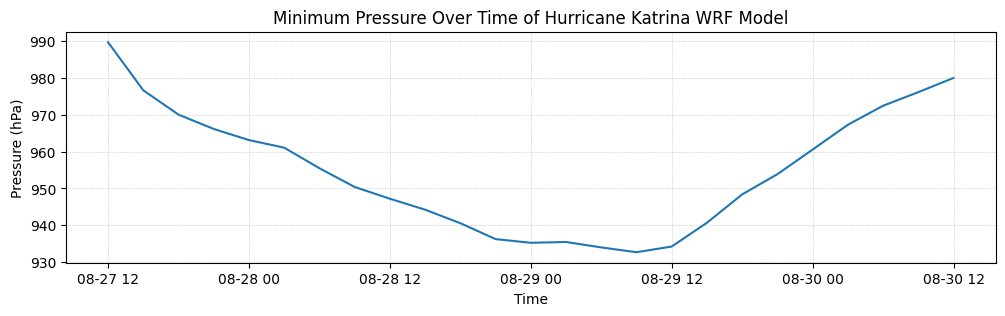

In [124]:
# Min pressure time series
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(min_pres_points.time, min_pres_points)
ax.set_title('Minimum Pressure Over Time of Hurricane Katrina WRF Model')
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Time')
ax.grid(True, linewidth=0.5, color='gray', alpha=0.6, linestyle=':')
plt.show()

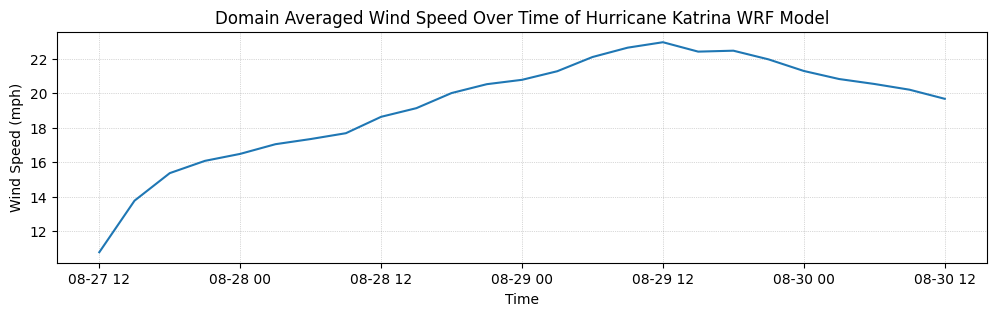

In [ ]:
# Domain avg wind time series
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(domain_avg_wind.time, domain_avg_wind)
ax.set_title('Domain Averaged Wind Speed Over Time of Hurricane Katrina WRF Model')
ax.set_ylabel('Wind Speed (mph)')
ax.set_xlabel('Time')
ax.grid(True, linewidth=0.5, color='gray', alpha=0.6, linestyle=':')
plt.show()

### (4)  Finally - interpretation time!  Looking at your line plots in Q3 - do you notice a relationship between how the minimum pressure changes over time and how the domain-average wind speed changes over time?  If so - describe it in a sentence or two!

Yes, I do notice a relationship. Up through around 12z on August 29, the wind speed increases with time while pressure decreases, and then after 12z, they both reverse direction. This makes sense as a lower pressure means a stronger storm and generally stronger wind speeds as a result, while higher pressure means a weaker storm and weaker winds as a result. 